In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil

In [2]:


#data_directory = './data/img_data/dustan/poly/mel_freq/'

data_directory = './data/img_data/dustan/poly/mel_spectrogram/'

data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory, labels='inferred', label_mode='int', image_size=(432, 288), seed=321,
    validation_split=None, subset=None)


class_names = data_ds.class_names
print(class_names)

Found 119 files belonging to 3 classes.
['discomfort', 'hungry', 'tired']


In [3]:
## create model

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [5]:
def dummy(data):
    new_data =[]
    for i in data:
        #lab_data =[0,0,0,0,0]
        lab_data =[0,0,0]
        #lab_data =[0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [6]:
feature=[]
label=[]
for images, labels in data_ds.unbatch().take(-1):
    feature.append(images.numpy())
    label.append(labels.numpy())

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train,x_test,y_train,y_test = train_test_split(feature,label,test_size = 0.20,random_state =101)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
class_count = np.array([np.count_nonzero(y_train ==0),np.count_nonzero(y_train ==1),np.count_nonzero(y_train ==2),np.count_nonzero(y_train ==3),np.count_nonzero(y_train ==4)])

In [11]:
class_count = np.array([np.count_nonzero(y_train ==0),np.count_nonzero(y_train ==1),np.count_nonzero(y_train ==2)])

In [12]:
class_count = np.array([np.count_nonzero(y_train ==0),np.count_nonzero(y_train ==1)])

In [13]:
y_train = dummy(y_train)
y_test = dummy(y_test)

In [242]:
class_count

array([21, 32, 42])

In [243]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [244]:
img_height = 432
img_width = 288

In [246]:
num_classes = 3
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [247]:
#class_weights = {0:0, 1:0,2:0,3:0,4:0}
class_weights = {0:0, 1:0,2:0}
for i in range(num_classes):
    class_weights[i]=create_weight(109,num_classes,class_count[i])

In [248]:
class_weights

{0: 1.7301587301587302, 1: 1.1354166666666667, 2: 0.8650793650793651}

In [249]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top

inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)

x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.2)(x)
            
x = tf.keras.layers.GlobalAveragePooling2D()(x)

#x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(3,activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_6 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

In [250]:
''' #model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary() '''

" #model = tf.keras.Sequential([\n            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            \n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Flatten(),\n            tf.keras.layers.Dense(64, activation='relu'),\n            tf.keras.layers.Dense(1, activation='sigmoid')\n        ])\nmodel.summary() "

In [251]:
#resnet 
#inception v3

In [252]:

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [253]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [254]:
# Set the epocks
# ทำ stop + validation
epochs = 100
#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights)
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 15s 4s/step - loss: 12.5407 - accuracy: 0.3026 - val_loss: 1.8046 - val_accuracy: 0.7895
Epoch 2/100
3/3 [==============================] - 10s 3s/step - loss: 3.1632 - accuracy: 0.5658 - val_loss: 1.3216 - val_accuracy: 0.2105
Epoch 3/100
3/3 [==============================] - 10s 3s/step - loss: 1.1743 - accuracy: 0.5132 - val_loss: 1.2616 - val_accuracy: 0.2632
Epoch 4/100
3/3 [==============================] - 10s 3s/step - loss: 0.7868 - accuracy: 0.5263 - val_loss: 0.9474 - val_accuracy: 0.3158
Epoch 5/100
3/3 [==============================] - 10s 3s/step - loss: 0.7329 - accuracy: 0.6184 - val_loss: 0.8062 - val_accuracy: 0.2632
Epoch 6/100
3/3 [==============================] - 10s 3s/step - loss: 0.6669 - accuracy: 0.6316 - val_loss: 0.6884 - val_accuracy: 0.7895
Epoch 7/100
3/3 [==============================] - 10s 3s/step - loss: 0.5353 - accuracy: 0.8816 - val_loss: 0.6643 - val_accuracy: 0.7895
Epoch 8/100
3/3 [=====================

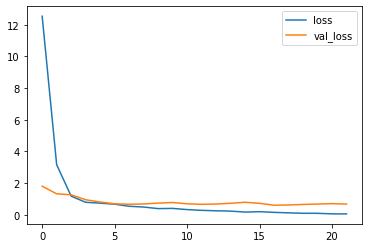

In [255]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [256]:
pred = model.predict(x_test)

y_pred = np.argmax(pred, axis=1)
actual = x_test

<function matplotlib.pyplot.show(*args, **kw)>

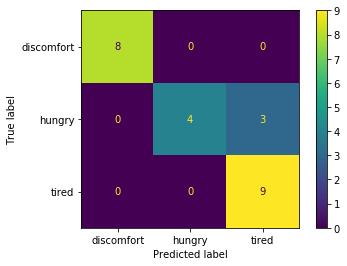

In [257]:
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [258]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 50
#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights)
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,callbacks=callback,class_weight = class_weights)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 432, 288, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 432, 288, 3)       0         
                                                                 
 tf.cast_6 (TFOpLambda)      (None, 432, 288, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 14, 9, 2048)       23564800  
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 9, 128)        2359424   
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 4, 128)        0         
 g2D)                                                            
                                                           

c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 46s 11s/step - loss: 0.1767 - binary_accuracy: 0.9596 - val_loss: 0.4196 - val_binary_accuracy: 0.9080
Epoch 2/50
3/3 [==============================] - 39s 11s/step - loss: 0.1049 - binary_accuracy: 0.9848 - val_loss: 0.7523 - val_binary_accuracy: 0.7816
Epoch 3/50
3/3 [==============================] - 39s 11s/step - loss: 0.1029 - binary_accuracy: 0.9697 - val_loss: 0.6491 - val_binary_accuracy: 0.8621
Epoch 4/50
3/3 [==============================] - 39s 11s/step - loss: 0.0352 - binary_accuracy: 1.0000 - val_loss: 0.5086 - val_binary_accuracy: 0.8966
Epoch 5/50
3/3 [==============================] - 41s 12s/step - loss: 0.0472 - binary_accuracy: 0.9949 - val_loss: 0.4025 - val_binary_accuracy: 0.9195
Epoch 6/50
3/3 [==============================] - 43s 11s/step - loss: 0.0186 - binary_accuracy: 1.0000 - val_loss: 0.3664 - val_binary_accuracy: 0.9310
Epoch 7/50
3/3 [==============================] - 39s 11s/step - loss: 0.0134 - binary_accura

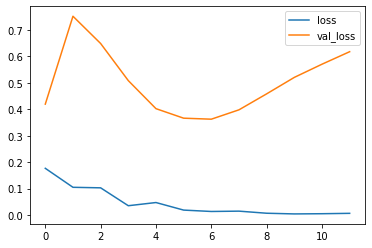

In [259]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [260]:
pred = model.predict(x_test)

y_pred = np.argmax(pred, axis=1)
actual = x_test

<function matplotlib.pyplot.show(*args, **kw)>

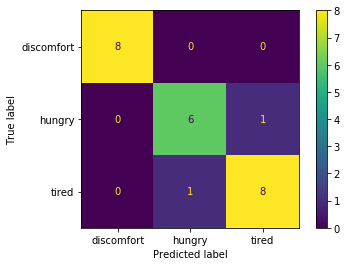

In [261]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [262]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=class_names))

              precision    recall  f1-score   support

  discomfort       1.00      1.00      1.00         8
      hungry       0.86      0.86      0.86         7
       tired       0.89      0.89      0.89         9

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.92        24
weighted avg       0.92      0.92      0.92        24

